
## Exploratory Data Analysis

In [66]:
import pandas as pd
import numpy as np

In [67]:
df = pd.read_csv('data/ai_job_dataset.csv')

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   job_id                  15000 non-null  object 
 1   job_title               15000 non-null  object 
 2   salary_usd              15000 non-null  int64  
 3   salary_currency         15000 non-null  object 
 4   experience_level        15000 non-null  object 
 5   employment_type         15000 non-null  object 
 6   company_location        15000 non-null  object 
 7   company_size            15000 non-null  object 
 8   employee_residence      15000 non-null  object 
 9   remote_ratio            15000 non-null  int64  
 10  required_skills         15000 non-null  object 
 11  education_required      15000 non-null  object 
 12  years_experience        15000 non-null  int64  
 13  industry                15000 non-null  object 
 14  posting_date            15000 non-null

1. Dataset size:
    The dataset contains 15,000 rows and 19 columns — a manageable size for EDA and model training.

2. Missing values:
    All columns are fully populated (15000 non-null), meaning no missing data — excellent data quality.

3. Data types:
    - 14 object columns — categorical or text fields.
    - 4 int64 columns — likely numeric or coded features.
    - 1 float64 column (benefits_score).
    This shows that the dataset is categorical-heavy, requiring encoding before modeling.

4. Target variable:
    salary_usd is integer and complete — perfect for a regression problem.

In [69]:
df.head()

,job_id,job_title,salary_usd,salary_currency,experience_level,employment_type,company_location,company_size,employee_residence,remote_ratio,required_skills,education_required,years_experience,industry,posting_date,application_deadline,job_description_length,benefits_score,company_name
0,AI00001,AI Research Scientist,90376,USD,SE,CT,China,M,China,50,"Tableau, PyTorch, Kubernetes, Linux, NLP",Bachelor,9,Automotive,2024-10-18,2024-11-07,1076,5.9,Smart Analytics
1,AI00002,AI Software Engineer,61895,USD,EN,CT,Canada,M,Ireland,100,"Deep Learning, AWS, Mathematics, Python, Docker",Master,1,Media,2024-11-20,2025-01-11,1268,5.2,TechCorp Inc
2,AI00003,AI Specialist,152626,USD,MI,FL,Switzerland,L,South Korea,0,"Kubernetes, Deep Learning, Java, Hadoop, NLP",Associate,2,Education,2025-03-18,2025-04-07,1974,9.4,Autonomous Tech
3,AI00004,NLP Engineer,80215,USD,SE,FL,India,M,India,50,"Scala, SQL, Linux, Python",PhD,7,Consulting,2024-12-23,2025-02-24,1345,8.6,Future Systems
4,AI00005,AI Consultant,54624,EUR,EN,PT,France,S,Singapore,100,"MLOps, Java, Tableau, Python",Master,0,Media,2025-04-15,2025-06-23,1989,6.6,Advanced Robotics


1. snake_case format for column names — good
2. dont need job_id
3. categorical field values like job_title, company_location, and education_required are inconsistent:
    - mixed capitalization (e.g., AI Engineer, ai engineer);
    - spaces instead of underscores;
    - sometimes contain symbols or slashes (e.g., MLOps / Data Engineer).
4. required_skills - this column represents a multi-label categorical feature — a comma-separated list of skills. It should be preprocessed differently since it encodes multiple labels per sample, not just one.

In [70]:
# 2. don't need the id column
df = df[list(df.columns)[1:]]

In [71]:
# 3. Identify categorical columns
strings = list(df.dtypes[df.dtypes == 'object'].index)
strings.remove("required_skills")
strings

['job_title',
 'salary_currency',
 'experience_level',
 'employment_type',
 'company_location',
 'company_size',
 'employee_residence',
 'education_required',
 'industry',
 'posting_date',
 'application_deadline',
 'company_name']

In [72]:
for col in strings:
    df[col] = df[col].str.lower().str.replace(' ', '_')

In [73]:
# 4. Preprocess the required_skills column
df['required_skills'] = (
    df['required_skills']
    .astype(str)
    .str.lower()
    .str.strip()
    .str.replace(r'\s*,\s*', ',', regex=True)   # remove extra spaces around commas
    .str.replace(r'[^a-z0-9,]', '', regex=True) # remove special chars
    .apply(lambda x: x.split(',') if x else [])
)

# Preview one example
df['required_skills'].head()

0          [tableau, pytorch, kubernetes, linux, nlp]
1    [deeplearning, aws, mathematics, python, docker]
2       [kubernetes, deeplearning, java, hadoop, nlp]
3                         [scala, sql, linux, python]
4                      [mlops, java, tableau, python]
Name: required_skills, dtype: object

In [74]:
# Final preview of cleaned dataframe
df.head()

,job_title,salary_usd,salary_currency,experience_level,employment_type,company_location,company_size,employee_residence,remote_ratio,required_skills,education_required,years_experience,industry,posting_date,application_deadline,job_description_length,benefits_score,company_name
0,ai_research_scientist,90376,usd,se,ct,china,m,china,50,"[tableau, pytorch, kubernetes, linux, nlp]",bachelor,9,automotive,2024-10-18,2024-11-07,1076,5.9,smart_analytics
1,ai_software_engineer,61895,usd,en,ct,canada,m,ireland,100,"[deeplearning, aws, mathematics, python, docker]",master,1,media,2024-11-20,2025-01-11,1268,5.2,techcorp_inc
2,ai_specialist,152626,usd,mi,fl,switzerland,l,south_korea,0,"[kubernetes, deeplearning, java, hadoop, nlp]",associate,2,education,2025-03-18,2025-04-07,1974,9.4,autonomous_tech
3,nlp_engineer,80215,usd,se,fl,india,m,india,50,"[scala, sql, linux, python]",phd,7,consulting,2024-12-23,2025-02-24,1345,8.6,future_systems
4,ai_consultant,54624,eur,en,pt,france,s,singapore,100,"[mlops, java, tableau, python]",master,0,media,2025-04-15,2025-06-23,1989,6.6,advanced_robotics


In [75]:
# Check for missing values
df.isna().sum()

job_title                 0
salary_usd                0
salary_currency           0
experience_level          0
employment_type           0
company_location          0
company_size              0
employee_residence        0
remote_ratio              0
required_skills           0
education_required        0
years_experience          0
industry                  0
posting_date              0
application_deadline      0
job_description_length    0
benefits_score            0
company_name              0
dtype: int64

Nice, has no missing values

In [76]:
target = 'salary_in_usd'

In [77]:
cat_columns = df.select_dtypes(include=['object']).columns.tolist()
cat_columns = [cols for cols in cat_columns if cols != target]
cat_columns

['job_title',
 'salary_currency',
 'experience_level',
 'employment_type',
 'company_location',
 'company_size',
 'employee_residence',
 'required_skills',
 'education_required',
 'industry',
 'posting_date',
 'application_deadline',
 'company_name']

In [78]:
# Сheck unique values of categorical columns
for cols in cat_columns:
    print(cols)
    print(df[cols].value_counts())
    print()

job_title
job_title
machine_learning_researcher    808
ai_software_engineer           784
autonomous_systems_engineer    777
machine_learning_engineer      772
ai_architect                   771
head_of_ai                     765
nlp_engineer                   762
robotics_engineer              759
data_analyst                   759
ai_research_scientist          756
data_engineer                  749
ai_product_manager             743
research_scientist             742
principal_data_scientist       734
ai_specialist                  728
ml_ops_engineer                725
computer_vision_engineer       724
data_scientist                 720
deep_learning_engineer         718
ai_consultant                  704
Name: count, dtype: int64

salary_currency
salary_currency
usd    11957
eur     2314
gbp      729
Name: count, dtype: int64

experience_level
experience_level
mi    3781
ex    3760
se    3741
en    3718
Name: count, dtype: int64

employment_type
employment_type
ft    3812
fl    3

1. job_title: 
2. salary_currency: 
 - There are three currencies: USD, EUR, and GBP.
 - To maintain consistency, convert all salaries to USD using approximate 2025 exchange rates, or alternatively keep only USD rows if a localized model is desired.

3. experience_level
 - Each group is well balanced (~25% each), making it an excellent categorical predictor.
4. employment_type
 - All types are evenly distributed — no resampling required.

5. company_location:
 - top 20 (Germany, France, Canada, China, etc.) having 700–800 records each.
 - The distribution is fairly balanced across major economies.
 - Recommendation: Keep the top 20 countries. Replace the rest with "other". The distribution is fairly balanced across major economies.

6. company_size:
 - Three balanced categories: s, m, l (small, medium, large).
 - Perfectly distributed (≈5000 each).

7. employee_residence
 - Similar distribution to company_location — top 20 countries evenly represented.
 - Recommendation: Compare with company_location to determine overlap or keep both if they differ.

8. required_skills
 - Multi-label feature: each row contains a comma-separated list of skills.

9. education_required
 - The distribution is even across all education levels.


10. industry
 - All are evenly distributed (~956–1063 jobs each).

11. posting_date
 - High cardinality (486 and 543 unique values respectively).
 - Not useful as raw categorical data.

12. application_deadline
 - High cardinality (486 and 543 unique values respectively).
 - Not useful as raw categorical data.

13. company_name:
 - Dozens of company identifiers (techcorp_inc, ai_innovations, etc.), all similarly frequent.
 - Not generalizable across datasets.
 - Recommendation: Do not use directly in modeling.
 

In [79]:
# Describing the dataset
df.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
salary_usd,15000.0,115348.97,60260.94,32519.0,70179.75,99705.0,146408.5,399095.0
remote_ratio,15000.0,49.48,40.81,0.0,0.00,50.0,100.0,100.0
years_experience,15000.0,6.25,5.55,0.0,2.00,5.0,10.0,19.0
job_description_length,15000.0,1503.31,576.13,500.0,1003.75,1512.0,2000.0,2499.0
benefits_score,15000.0,7.50,1.45,5.0,6.20,7.5,8.8,10.0


In [80]:
df.isna().mean().sort_values(ascending=False).head(20)


job_title                 0.0
salary_usd                0.0
benefits_score            0.0
job_description_length    0.0
application_deadline      0.0
posting_date              0.0
industry                  0.0
years_experience          0.0
education_required        0.0
required_skills           0.0
remote_ratio              0.0
employee_residence        0.0
company_size              0.0
company_location          0.0
employment_type           0.0
experience_level          0.0
salary_currency           0.0
company_name              0.0
dtype: float64

df.isna().sum() 
df.describe(numeric_only=True)

In [81]:
df.describe(include=[np.number])

,salary_usd,remote_ratio,years_experience,job_description_length,benefits_score
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,115348.965133,49.483333,6.253200,1503.314733,7.504273
std,60260.940438,40.812712,5.545768,576.127083,1.450870
min,32519.000000,0.000000,0.000000,500.000000,5.000000
25%,70179.750000,0.000000,2.000000,1003.750000,6.200000
50%,99705.000000,50.000000,5.000000,1512.000000,7.500000
75%,146408.500000,100.000000,10.000000,2000.000000,8.800000
max,399095.000000,100.000000,19.000000,2499.000000,10.000000


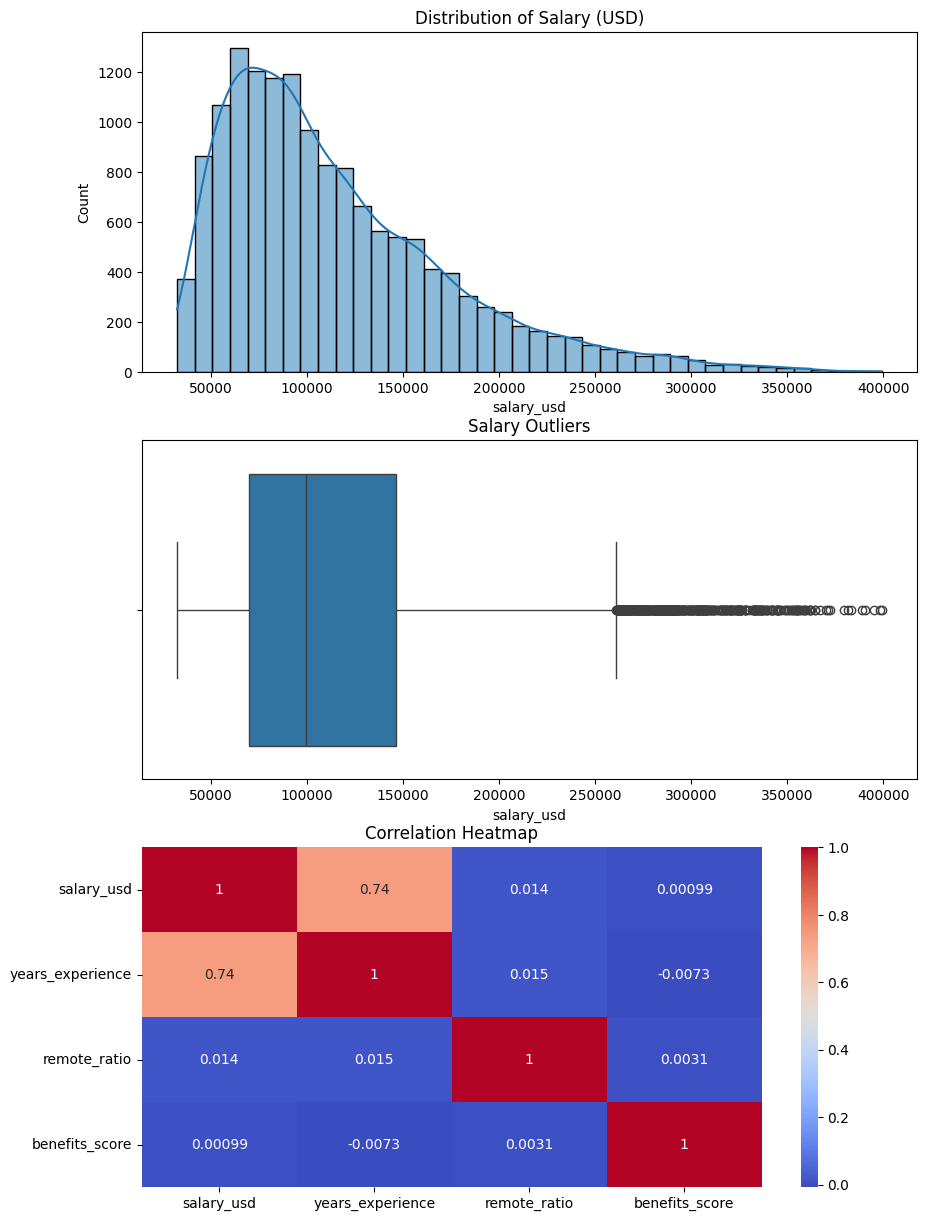

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(3, 1, figsize=(10, 15))  # 3 рядки, 1 колонка
sns.histplot(df['salary_usd'], bins=40, kde=True, ax=axes[0])
axes[0].set_title("Distribution of Salary (USD)")
print()

sns.boxplot(x=df['salary_usd'], ax=axes[1])
axes[1].set_title("Salary Outliers")
print()

sns.heatmap(df[['salary_usd','years_experience','remote_ratio','benefits_score']].corr(), annot=True, cmap='coolwarm', ax=axes[2])
axes[2].set_title("Correlation Heatmap")

plt.show()

1. Salary Distribution

- The salary distribution is heavily right-skewed.
Most salaries fall between $50K–$150K, while a small number exceed $200K+.

- This skewness suggests the presence of high-earning roles (senior or executive positions).

 Recommended:

- Apply log transformation to stabilize variance.

- Or use robust models less sensitive to outliers.

2. Outliers

The boxplot shows many high-end outliers above 250K.
These likely correspond to top-tier roles, so they should not be dropped
but handled carefully in scaling or log transformation.

| Pair                          | Corr      | Interpretation                                                        |
| ----------------------------- | --------- | --------------------------------------------------------------------- |
| salary_usd ↔ years_experience | **0.74**  | **Strong positive correlation** — experience strongly affects salary. |
| salary_usd ↔ remote_ratio     | **0.014** | **Almost no relationship** — remote work doesn’t impact pay directly. |
| salary_usd ↔ benefits_score   | **0.001** | **No correlation** — benefits level is independent of pay.            |


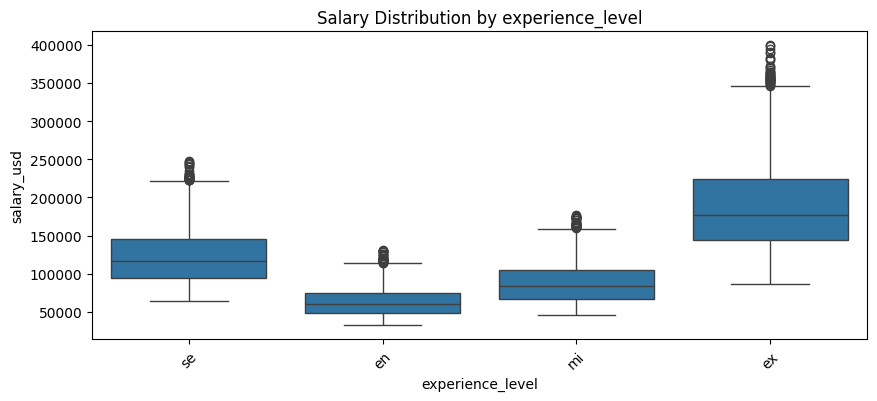

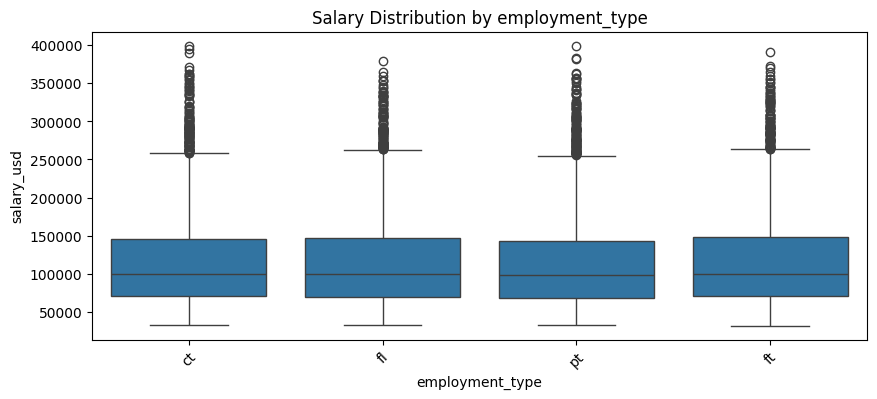

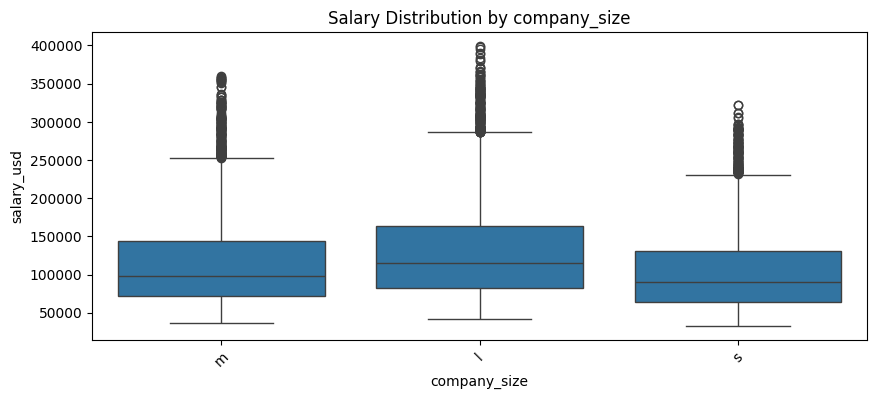

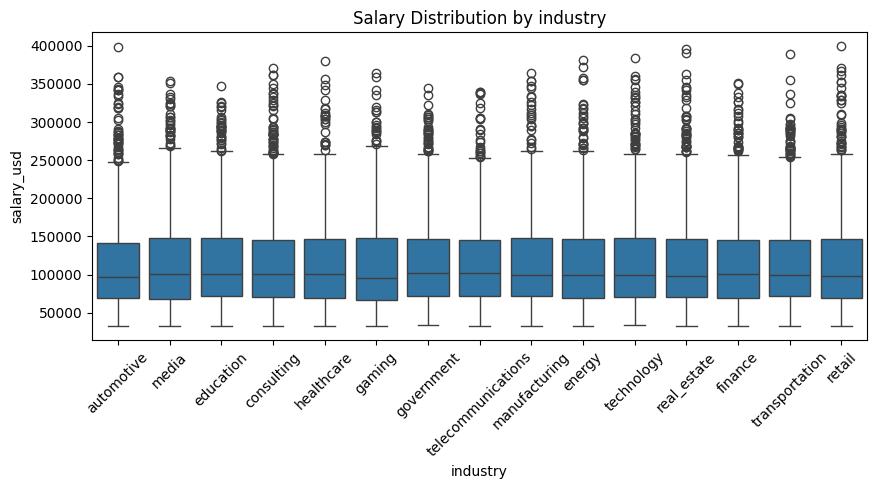

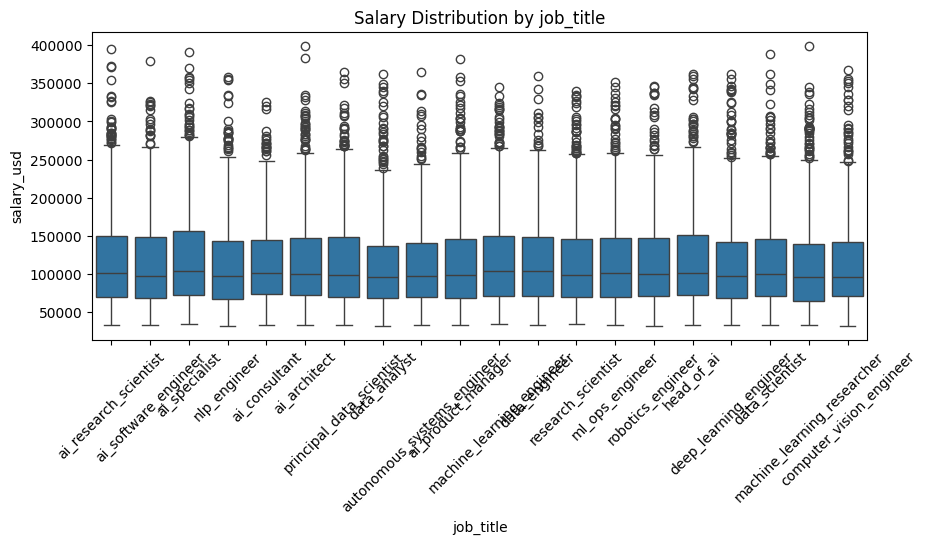

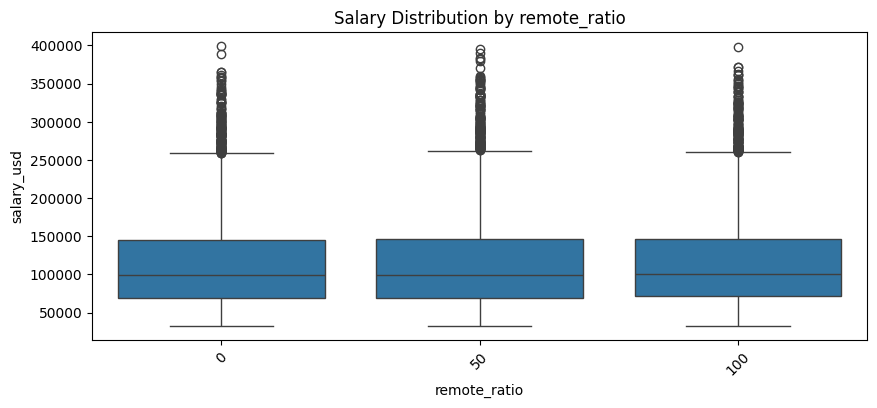

In [87]:
cat_columns = ['experience_level', 'employment_type', 'company_size', 'industry', 'job_title', 'remote_ratio']

for col in cat_columns:
    plt.figure(figsize=(10,4))
    sns.boxplot(x=col, y='salary_usd', data=df)
    plt.title(f"Salary Distribution by {col}")
    plt.xticks(rotation=45)
    plt.show()

*Experience Level*

- Salaries increase consistently with experience level. This confirms that experience_level is one of the strongest predictors of salary.

*Employment Type*

 - Median salaries are close to 100K USD in all groups.

*Company Size*
 - Large companies (L) tend to pay slightly higher salaries on average than Medium (M) and Small (S) ones.
 - However, the differences are not extreme — all medians cluster near 100–120K USD.

*Industr*
 - Median salaries are relatively consistent across all industries.

*Job Title*
 - Suggests that job seniority and leadership roles, not just technical titles, drive higher pay.

*Remote Ratio*
 - Salary distributions for all positions are almost identical.
